# ROC & PrAUC Optimization



In [1]:
%config Completer.use_jedi = False

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

plt.style.use("ggplot")

# Data

Imbalanced Data 를 생성합니다. <br>
이때 make_classification 함수를 사용하면 좋습니다. 

In [2]:
x_data, y_data = make_classification(
    n_samples=10000,
    n_features=5,
    n_classes=2,
    weights=(0.9, 0.1),
    flip_y=0.05,
    random_state=1,
)

x_data = pd.DataFrame(x_data, columns=["x1", "x2", "x3", "x4", "x5"])
y_data = pd.DataFrame(y_data.reshape(-1, 1), columns=["y"])
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=2)

# Display Data
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test :", x_test.shape)
print("y_test :", y_test.shape)
display(y_data.value_counts())
display(x_data.join(y_data).head())

x_train: (7000, 5)
y_train: (7000, 1)
x_test : (3000, 5)
y_test : (3000, 1)


y
0    8781
1    1219
dtype: int64

,x1,x2,x3,x4,x5,y
0,-1.001202,-1.144739,0.542759,-1.213478,-1.515303,0
1,0.762951,-0.367625,0.055824,-1.785367,0.564202,0
2,-0.705091,0.273111,-0.026364,-0.598962,-0.553148,0
3,1.925754,-1.470852,0.346450,-0.684048,1.165529,0
4,1.520116,-1.642537,0.455763,1.206765,0.690714,0


# Logistic Regression



In [3]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver="lbfgs")
model.fit(x_train, y_train.values.reshape(-1))

y_prob = model.predict_proba(x_test)[:, 1]

## ROC Curve and AUC

**AUC**
- 0.5: 전혀 못 맞춤
- 1: 다 맞춤


Logistic Regression | max_threshold: 0.2602149760968574


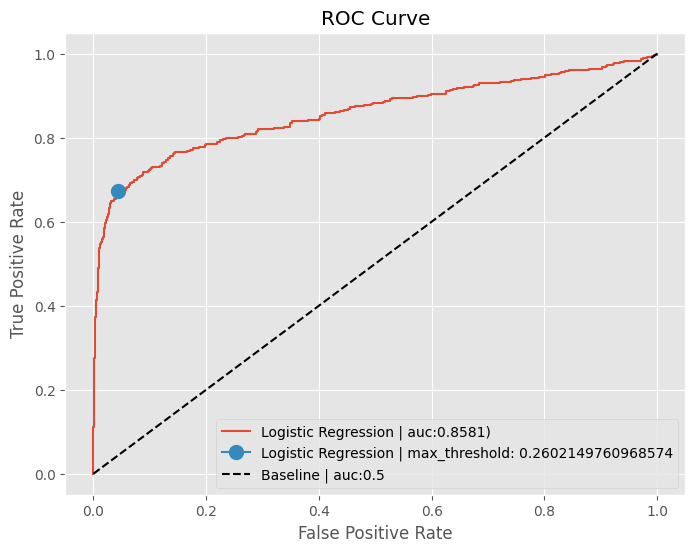

In [31]:
from sklearn.metrics import (
    RocCurveDisplay,
    accuracy_score,
    auc,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)


def calculate_roc(y_true, y_prob, plot, label, method=None):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    
    # TPR - FPR Optimal Threshold
    if method == 'gmean':
        gmeans = np.sqrt(tpr * (1 - fpr))
        max_idx = np.argmax(gmeans)
        max_threshold = thresholds[max_idx]
    elif method == 'diff':
        max_idx = np.argmax(tpr - fpr)
        max_threshold = thresholds[max_idx]
    else:
        max_idx = np.argmax(tpr - fpr)
        max_threshold = thresholds[max_idx]
    
    # Other Metrics at the max_threshold
    auc_ = auc(fpr, tpr)
    acc_ = accuracy_score(y_true, y_prob >= max_threshold)
    f1_ = f1_score(y_true, y_prob >= max_threshold)
    
    plot.plot(fpr, tpr, label=f"{label} | auc:{auc_:.4f})")
    plot.plot(fpr[max_idx], tpr[max_idx], marker="o", markersize=10, 
              label=f'{label} | max_threshold: {max_threshold}')
    
    print(f'{label} | max_threshold: {max_threshold}')
    
    
fig, plot = plt.subplots(1, figsize=(8, 6))
calculate_roc(y_test, y_prob, plot, 'Logistic Regression')

plot.plot([0, 1], [0, 1], "k--", label=f"Baseline | auc:0.5")
plot.set_xlabel("False Positive Rate")
plot.set_ylabel("True Positive Rate")
plot.set_title(f"ROC Curve")
plot.legend(loc="lower right")


# PRAUC

이후 특정 Threshld 의 AUC 를 계산 하는 방법은 다음과 같이 합니다. 

('diff', 'plus', 'f1')
aa


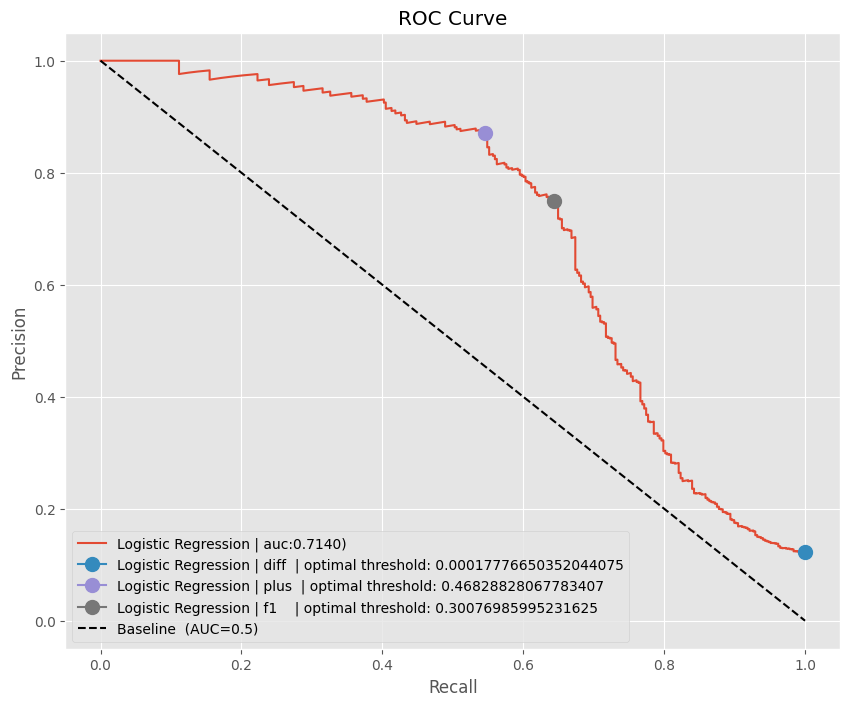

In [83]:
from sklearn.metrics import auc, precision_recall_curve

def calculate_prauc(y_true, y_prob, plot, label, method=[]):
    from collections.abc import Iterable
    
    def point_optimal_threshold(name):
        
        # Other Metrics at the max_threshold
        
        acc_ = accuracy_score(y_true, y_prob >= max_threshold)
        f1_ = f1_score(y_test, y_prob >= max_threshold)

        plot.plot(recall[max_idx], precision[max_idx], marker="o", markersize=10, 
              label=f'{label} | {name:5} | optimal threshold: {max_threshold}')
        
    
    if not isinstance(method, Iterable):
        method = [method]
        
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    auc_ = auc(recall, precision)
    plot.plot(recall, precision, label=f"{label} | auc:{auc_:.4f})")
    
    # Optimize the thesholds
    print(method)
    if 'diff' in method:
        print('aa')
        max_idx = np.argmax(recall - precision)
        max_threshold = thresholds[max_idx]
        point_optimal_threshold('diff')
        
    if 'plus' in method :
        max_idx = np.argmax(recall + precision)
        max_threshold = thresholds[max_idx]
        point_optimal_threshold('plus')
        
    if 'f1' in method:
        fscores = 2 * (precision * recall) / (precision + recall)
        max_idx = np.argmax(fscores)
        max_threshold = thresholds[max_idx]
        point_optimal_threshold('f1')
        
    
    
    
fig, plot = plt.subplots(1, figsize=(10, 8))
calculate_prauc(y_test, y_prob, plot, 'Logistic Regression', method=('diff', 'plus', 'f1'))


plot.plot([0, 1], [1, 0], "k--", label=f"Baseline  (AUC=0.5)")
plot.set_xlabel("Recall")
plot.set_ylabel("Precision")
plot.set_title(f"ROC Curve")
plot.legend(loc="lower left")

## 

# Threshold Tuning

모델 하나있고.. ROC 니.. PRAUC 니 그런거 모르겠고.. 
그냥 빠르게 찾고자 할때 사용하면 좋습니다. 

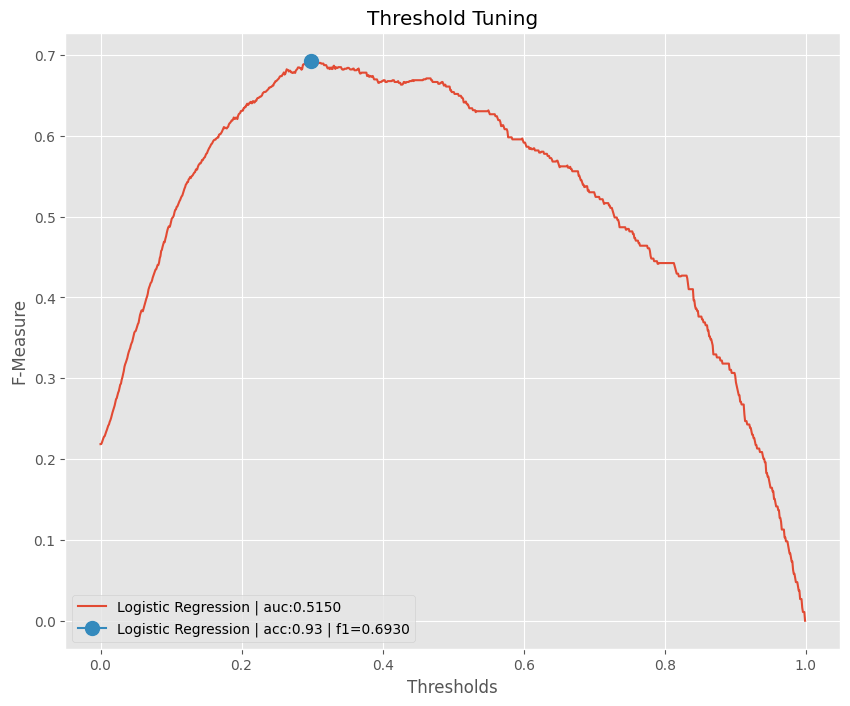

In [97]:
from sklearn.metrics import f1_score

def calculate_threshold_tuning(y_true, y_prob, plot, label):
    thresholds = np.arange(0, 1, 0.001)
    scores = [f1_score(y_true, y_prob >= t) for t in thresholds]
    max_idx = np.argmax(scores)
    max_threshold = thresholds[max_idx]
    
    # Main line
    auc_ = auc(thresholds, scores)
    plot.plot(thresholds, scores, label=f"{label} | auc:{auc_:.4f}")
    
    # Other metrics
    acc_ = accuracy_score(y_true, y_prob >= max_threshold)
    f1_ = f1_score(y_true, y_prob >= max_threshold)
    optimal_msg = f"{label:18} | acc:{acc_:.2f} | f1={f1_:.4f}"
    plt.plot(thresholds[max_idx], scores[max_idx], marker="o", markersize=10, 
             label=f'{optimal_msg}')
    
    
    
fig, plot = plt.subplots(1, figsize=(10, 8))
calculate_threshold_tuning(y_test, y_prob, plot, 'Logistic Regression')

plot.set_title(f"Threshold Tuning")
plot.set_xlabel("Thresholds")
plot.set_ylabel("F-Measure")
plot.legend(loc="lower left")


## 특정 Threshold 에서의 AUC

정확하게 이런 방법은 ML책에 나오는 방법은 아닙니다. <br>
그래서 이런 지표에 대한 이름도 딱히 없습니다. <br> 
지난번 Baysian 공식을 엮으로 엮어서 casuality analysis 한것 처럼 우린 그냥 수식을 이용해서 문제를 해결할 뿐입니다.<br> 

특정 threshold 를 걸어주게되면, 이미 특정 threshold 기준으로 probability가 고정이 됩니다. <br>
이 기준을 해당 기준을 갖고서 AUC를 구했을때의 지표입니다.

예제는 다음과 같습니다. 
- target_threshold=0.3 : 해당 0.3 PRAUC 에서 F1-Score의 optimal threshold 입니다. 
- target_threshold=0.9 : 그냥 임의로 정한 값입니다. (비교를 위해서)

0.3 threshold의 경우는 AUC 0.7140이 나옵니다. <br>
0.9 threshold의 경우는 AUC 0.6253이 나옵니다. 

이런 방식을 사용해서 모델간의 성능을 비교하기도 합니다. <br>
다만.. 위에서 이야기 했듯이 공식적으로 있는 건 아니기 때문에 뭐라고 해야 할지 모르겠네요. 

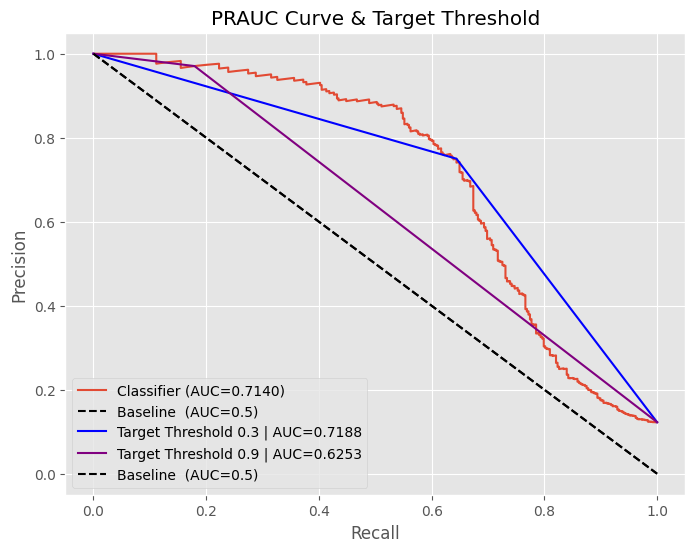

In [126]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# F-Measure (F1-Score)
fscores = 2 * (precision * recall) / (precision + recall)
idx1 = np.argmax(fscores)


# Plot
roc_auc = auc(recall, precision)
fig, plot = plt.subplots(1, figsize=(8, 6))
plot.plot(recall, precision, label=f"Classifier (AUC={roc_auc:.4f})")
plot.plot([0, 1], [1, 0], "k--", label=f"Baseline  (AUC=0.5)")


# Threshold 0.3 에서의 AUC
target_threshold = 0.3
precision, recall, thresholds = precision_recall_curve(y_test, y_prob >= target_threshold)
plot.plot(recall, precision, color='blue', label=f"Target Threshold {target_threshold} | AUC={auc(recall, precision):.4f}")

# Threshold 0.9 에서의 AUC
target_threshold = 0.9
precision, recall, thresholds = precision_recall_curve(y_test, y_prob >= target_threshold)
plot.plot(recall, precision, color='purple', label=f"Target Threshold {target_threshold} | AUC={auc(recall, precision):.4f}")


plot.plot([0, 1], [1, 0], "k--", label=f"Baseline  (AUC=0.5)")

plot.set_xlabel("Recall")
plot.set_ylabel("Precision")
plot.set_title(f"PRAUC Curve & Target Threshold")
plot.legend(loc="lower left")

In [112]:
np.unique(thresholds).shape

(2998,)